In [3]:
"""Importing Important libraries"""

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.stats import gaussian_kde


In [2]:
"""Read the data from jupyter"""
data = pd.read_csv('data_new.csv', index_col = 0)
data.head(5)

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,255,2FOI,50,ML,TRO,0,40,193.0,NaN,18.25
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,18,1COJ0FIK,50,ST,TAB,1,40,66.0,C,18.81
2,3,1,16382,0,1,14.77,0,1,0,16.06,...,41,22OI7,2X50,ML,STI,0,53,40.0,NaN,18.48
3,4,1,1145,1,1,6.59,0,0,1,6.55,...,52,18OZ00IS,60,G,GEL,0,40,25.0,NaN,9.31
4,5,1,3394,0,1,4.39,0,0,1,4.14,...,90,20OI0,25X2,ST,KOM,0,53,14.0,NaN,8.13


In [4]:
import boto3

"""Saving the csv to Bucket"""

def save_csv_to_s3(csv_file, s3_bucket, s3_key):
    """Saves a CSV file to an S3 bucket.

    Args:
        csv_file (str): Path to the CSV file.
        s3_bucket (str): Name of the S3 bucket.
        s3_key (str): Key (path) within the S3 bucket where the file will be saved.
    """

    try:
        s3 = boto3.client('s3')
        with open(csv_file, 'rb') as f:
            s3.upload_fileobj(f, s3_bucket, s3_key)
        print(f"CSV file '{csv_file}' uploaded to S3 bucket '{s3_bucket}' as '{s3_key}'.")
    except Exception as e:
        print(f"Error uploading CSV file: {e}")


In [ ]:
# Example usage:
csv_file_path = "data_new.csv"
s3_bucket_name = "dynamic-price-forecasting"
s3_key_path = "data/raw_data/data_new"

save_csv_to_s3(csv_file_path, s3_bucket_name, s3_key_path)

In [5]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2756003 entries, 0 to 2756002
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   lineID           int64  
 1   day              int64  
 2   pid              int64  
 3   adFlag           int64  
 4   availability     int64  
 5   competitorPrice  float64
 6   click            int64  
 7   basket           int64  
 8   order            int64  
 9   price            float64
 10  revenue          float64
 11  manufacturer     int64  
 12  group            object 
 13  content          object 
 14  unit             object 
 15  pharmForm        object 
 16  genericProduct   int64  
 17  salesIndex       int64  
 18  category         float64
 19  campaignIndex    object 
 20  rrp              float64
dtypes: float64(5), int64(11), object(5)
memory usage: 462.6+ MB


In [7]:
# Numerical and Categorical columns
cat_cols = ['group', 'content', 'unit', 'pharmForm', 'campaignIndex']
num_cols = [i for i in data.columns if i not in cat_cols]

In [12]:
# Print 
print(f"Numerical cols: {num_cols}\n")
print(f"Categorical cols: {cat_cols}")

Numerical cols: ['lineID', 'day', 'pid', 'adFlag', 'availability', 'competitorPrice', 'click', 'basket', 'order', 'price', 'revenue', 'manufacturer', 'genericProduct', 'salesIndex', 'category', 'rrp']

Categorical cols: ['group', 'content', 'unit', 'pharmForm', 'campaignIndex']


In [14]:
"""Handling Missing Values"""
data[num_cols].isna().sum()

lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice    100687
click                   0
basket                  0
order                   0
price                   0
revenue                 0
manufacturer            0
genericProduct          0
salesIndex              0
category            87394
rrp                     0
dtype: int64

In [15]:
# So, there are two columns with extreme null values 
data['price_diff'] = data['price'] - data['competitorPrice']

print("Mean Difference bw price and comp price: ", data['price_diff'].mean())
print("\nInfo: ", data['price_diff'].describe())

Mean Difference bw price and comp price:  0.8650459342692172

Info:  count    2.655316e+06
mean     8.650459e-01
std      3.949754e+00
min     -1.423900e+02
25%     -4.000000e-02
50%      7.300000e-01
75%      1.850000e+00
max      1.368700e+02
Name: price_diff, dtype: float64


In [17]:
# Since the difference is just 0.86 we can select a value like 1 or 2 to impute the remaining ones 

# We ll fill the missing values for comp price with 1
data['compPrice'] = data['competitorPrice'].fillna(data['price'] - 1)

Null values:  87394


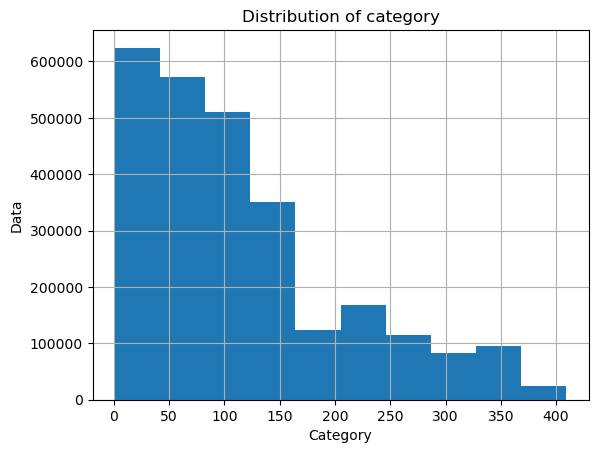

In [18]:
# Now for Category Column 
print("Null values: ", data['category'].isna().sum())
# Create a histogram
plt.hist(data['category'])
# Customize the plot
plt.xlabel('Category') 
plt.ylabel('Data') 
plt.title('Distribution of {}'.format('category'))  
plt.grid(True)  

# Display the plot
plt.show()

In [19]:
# So there are 400+ unique categories
# #1 We can randomly select (we assume these fall on these cats)
# #2 We can drop the rows 

# We choose to remove the rows 
data = data.dropna(subset=['category'])

In [21]:
print(f"Shape: {data.shape}")

print(f"Columns: {data.columns}")

Shape: (2668609, 23)
Columns: Index(['lineID', 'day', 'pid', 'adFlag', 'availability', 'competitorPrice',
       'click', 'basket', 'order', 'price', 'revenue', 'manufacturer', 'group',
       'content', 'unit', 'pharmForm', 'genericProduct', 'salesIndex',
       'category', 'campaignIndex', 'rrp', 'price_diff', 'compPrice'],
      dtype='object')


In [22]:
# Drop comp price and price diff 
data = data.drop(columns=['competitorPrice', 'price_diff'])

In [27]:
### all numerical column missing values have been handled 
# lets verify 
data.isna().sum()

lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
click                   0
basket                  0
order                   0
price                   0
revenue                 0
manufacturer            0
group                   0
content                 0
unit                    0
pharmForm          181456
genericProduct          0
salesIndex              0
category                0
campaignIndex     2202931
rrp                     0
compPrice               0
dtype: int64

In [29]:
## For Categorical columns
data[cat_cols].isna().sum()

group                  0
content                0
unit                   0
pharmForm         181456
campaignIndex    2202931
dtype: int64

In [31]:
# Taking top 5 instances in 'pharmForm' column
vc = data.pharmForm.value_counts()
top_five_cols = vc.head(5) 

In [32]:
print(f"Number of categories in vc: {len(vc)}")
vc

Number of categories in vc: 227


pharmForm
TAB    249499
CRE    189935
FTA    179827
GEL    144812
KAP    131536
        ...  
Saf         6
Lut         5
DES         4
Wka         3
Kmr         3
Name: count, Length: 227, dtype: int64

In [33]:
top_five_cols

pharmForm
TAB    249499
CRE    189935
FTA    179827
GEL    144812
KAP    131536
Name: count, dtype: int64

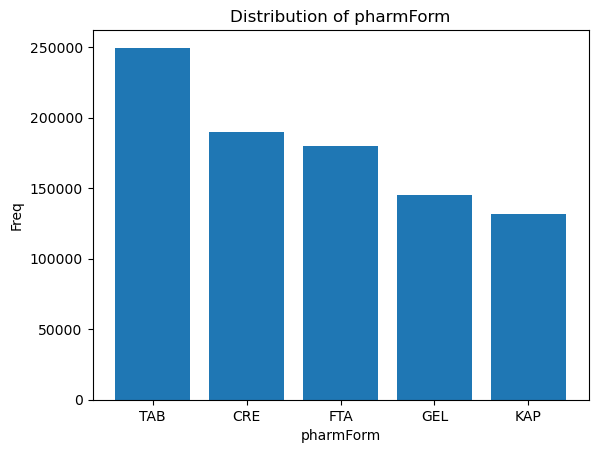

In [34]:
# pharmForm
data['pharmForm']

pharm_counts = data.pharmForm.value_counts()
# plt.figure(figsize=(10, 5))
plt.bar(top_five_cols.index, top_five_cols.values)

plt.xlabel('pharmForm')
plt.ylabel('Freq')
plt.title(f"Distribution of pharmForm")
plt.show()

In [35]:
# mode 
data['pharmForm'].mode()[0]

'TAB'

In [36]:
# fill this column with mode
data['pharmForm'].fillna(data['pharmForm'].mode()[0], inplace = True)

/tmp/ipykernel_8875/3314599048.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['pharmForm'].fillna(data['pharmForm'].mode()[0], inplace = True)


In [37]:
data['pharmForm'].isna().sum()

0

In [38]:
"""Campaign Index"""
print("null", data['campaignIndex'].isna().sum())

# Since there are more than 90% missing vals, we need to drop this column 
data.drop(columns=['campaignIndex'], inplace= True)

null 2202931


In [44]:
# Remove campaign index from the cat_cols list 
cat_cols = cat_cols[:len(cat_cols)-1]

In [47]:
data.isna().sum().sum()

0

In [50]:
### HURRAY, All missing values have been handled
# Lets save the dataframe to our bucket 

# lets call it data_v2.csv 
data.to_csv('data_v2.csv', index=False)
csv_file_path_for_datav2 = 'data_v2.csv'
s3_bucket_name = 'dynamic-price-forecasting'
s3_key_path_for_datav2 = 'data/raw_data/data_v2'

save_csv_to_s3(csv_file_path_for_datav2, s3_bucket_name, s3_key_path_for_datav2)

CSV file 'data_v2.csv' uploaded to S3 bucket 'dynamic-price-forecasting' as 'data/raw_data/data_v2'.


In [57]:
# import io
# def load_csv_from_s3(bucket_name, object_key):
#     s3 = boto3.client('s3')
#     response = s3.get_object(Bucket=bucket_name, Key=object_key)
#     csv_content = response['Body'].read().decode('utf-8')  # Assuming UTF-8 encoding

#     df = pd.read_csv(io.StringIO(csv_content))
#     return df

# # Example usage:
# bucket_name = 'dynamic-price-forecasting'
# object_key = 'data/raw_data/data_v2'

# df = load_csv_from_s3(bucket_name, object_key)

In [59]:
"""Normalization"""

# We will scale the data 
"""Encoding"""
from sklearn.preprocessing import OrdinalEncoder 

encoder = OrdinalEncoder()

# fit
encoder.fit(data[cat_cols])

data[cat_cols] = encoder.transform(data[cat_cols])

data.head(4)

,lineID,day,pid,adFlag,availability,click,basket,order,price,revenue,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp,compPrice
0,1,1,6570,0,2,1,0,0,16.89,0.00,255,514.0,366.0,5.0,171.0,0,40,193.0,18.25,14.60
1,2,1,14922,1,1,0,1,0,8.75,0.00,18,362.0,366.0,7.0,160.0,1,40,66.0,18.81,8.57
2,3,1,16382,0,1,0,1,0,16.06,0.00,41,489.0,237.0,5.0,151.0,0,53,40.0,18.48,14.77
3,4,1,1145,1,1,0,0,1,6.55,6.55,52,299.0,399.0,1.0,53.0,0,40,25.0,9.31,6.59


In [60]:
"""Feature selection"""
# price, rrp and compPrice are highly correlated so, we dont need

data = data.drop(columns=['lineID', 'rrp', 'compPrice'])
data.columns

Index(['day', 'pid', 'adFlag', 'availability', 'click', 'basket', 'order',
       'price', 'revenue', 'manufacturer', 'group', 'content', 'unit',
       'pharmForm', 'genericProduct', 'salesIndex', 'category'],
      dtype='object')

In [61]:
# Lets save the data before standardization
# lets call it data_v3.csv
data.to_csv('data_v3.csv', index=False)
csv_file_path_for_datav3 = 'data_v3.csv'
s3_bucket_name = 'dynamic-price-forecasting'
s3_key_path_for_datav3 = 'data/raw_data/data_v3'

save_csv_to_s3(csv_file_path_for_datav3, s3_bucket_name, s3_key_path_for_datav3)

CSV file 'data_v3.csv' uploaded to S3 bucket 'dynamic-price-forecasting' as 'data/raw_data/data_v3'.


In [141]:
"""Standardization"""
df = data
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

features = df.drop(columns=['revenue'])
target = df['revenue']

# Scaling
scaler.fit(features)
data_scaled = scaler.transform(features)
# data_scaled.head(3)

In [151]:
data_scaled.shape
d1 = pd.DataFrame(data_scaled, columns=features.columns).reset_index(drop=True)

d2 = target.reset_index(drop=True)
print(d1.shape)
print(d2.shape)

(2668609, 16)
(2668609,)


In [152]:
data_s = pd.concat([d2, d1], axis=1)

In [153]:
print(f"Shape: {data_s.shape}")
# data_scaled.head(3)

Shape: (2668609, 17)


In [155]:
# lets call it data_v4_s.csv
data_s.to_csv('data_v5_s.csv', index=False)
csv_file_path_for_datav5 = 'data_v5_s.csv'
s3_bucket_name = 'dynamic-price-forecasting'
s3_key_path_for_datav5 = 'data/raw_data/data_v5_s'

save_csv_to_s3(csv_file_path_for_datav5, s3_bucket_name, s3_key_path_for_datav5)

CSV file 'data_v5_s.csv' uploaded to S3 bucket 'dynamic-price-forecasting' as 'data/raw_data/data_v5_s'.


In [73]:
###### DATA PREPARATION HAS BEEN DONE 

##### MODEL BUILDING ----

In [5]:
# load the data_v5_s
data_s = pd.read_csv('data_v5_s.csv')
data_s.head(3)

,revenue,day,pid,adFlag,availability,click,basket,order,price,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category
0,0.0,-1.934013,-0.586131,-0.696640,2.537097,0.868028,-0.454814,-0.590134,0.229178,0.455885,1.160368,1.183135,-0.132315,1.300762,-0.348833,-0.950950,0.827978
1,0.0,-1.934013,0.707968,1.435461,-0.246040,-1.152037,2.198701,-0.590134,-0.373670,-0.833341,0.068416,1.183135,0.797724,1.105971,2.866704,-0.950950,-0.527564
2,0.0,-1.934013,0.934187,-0.696640,-0.246040,-1.152037,2.198701,-0.590134,0.167708,-0.708226,0.980770,0.336471,-0.132315,0.946597,-0.348833,1.075866,-0.805077


In [6]:
data_s.shape

(2668609, 17)

In [7]:
"""Split data in Train and Test"""

data_instances = data_s.shape[0]
# split into 80% and 20%
train_data_index = int(data_instances*0.8)

# train and validation data split
train_data = data_s[:train_data_index]
val_data = data_s[train_data_index:]

# print shape 
print(f"Shape of Train data: {train_data.shape}")
print(f"Shape of Val data: {val_data.shape}")

Shape of Train data: (2134887, 17)
Shape of Val data: (533722, 17)


In [8]:
"""Move Data to S3"""

# lets do it 
train_data.to_csv('data.csv', header=False, index=False)

# csv paths
train_data_csv_path = 'data.csv'

# bucket config
s3_bucket_name = 'dynamic-price-forecasting'
s3_key_path_for_train_data = 'training_data/train/data.csv'

save_csv_to_s3(train_data_csv_path, s3_bucket_name, s3_key_path_for_train_data)

CSV file 'data.csv' uploaded to S3 bucket 'dynamic-price-forecasting' as 'training_data/train/data.csv'.


In [9]:
# For validation data 
val_data.to_csv('data.csv', header=False, index=False)

# csv paths
val_data_csv_path = 'data.csv'

# bucket config
s3_bucket_name = 'dynamic-price-forecasting'
s3_key_path_for_val_data = 'training_data/validation/data.csv'

save_csv_to_s3(val_data_csv_path, s3_bucket_name, s3_key_path_for_val_data)

CSV file 'data.csv' uploaded to S3 bucket 'dynamic-price-forecasting' as 'training_data/validation/data.csv'.


In [10]:
##### MODEL Building
# imports 
import sagemaker 
import boto3 
import json
from sagemaker import get_execution_role
from sagemaker import image_uris, model_uris, script_uris

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [11]:
# aws configs
aws_role = get_execution_role()
print(f"Aws role: {aws_role}")

aws_region = boto3.Session().region_name
print(f"Region: {aws_region}")

sess = sagemaker.Session()
print(f"Session: {sess}")

Aws role: arn:aws:iam::730335477471:role/service-role/AmazonSageMaker-ExecutionRole-20240824T225568
Region: ap-southeast-2
Session: <sagemaker.session.Session object at 0x7fada49980d0>


In [13]:
"""Params"""
bucket_name = 'dynamic-price-forecasting'
# train data path
prefix = 'training_data'
training_dataset_s3_path = f"s3://{bucket_name}/{prefix}"

# output
output_prefix = "output"
s3_output_location = f"s3://{bucket_name}/{output_prefix}/model_output"

In [27]:
### Model config


from sagemaker import image_uris, model_uris, script_uris


train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"

# training_instance_type = "ml.m5.xlarge"
training_instance_type = "ml.c5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

In [25]:
### init hyperparameters
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500"  # The same hyperparameter is named as "iterations" for CatBoost
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


In [29]:
"""RUN TRAINING JOB"""

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)


# --------------------START TRAINING JOB----------------------
# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit(
    {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: jumpstart-lightgbm-regression-model-tra-2024-08-28-05-55-35-442


2024-08-28 05:55:35 Starting - Starting the training job...
2024-08-28 05:55:57 Starting - Preparing the instances for training...
2024-08-28 05:56:20 Downloading - Downloading input data...
2024-08-28 05:57:00 Downloading - Downloading the training image...
2024-08-28 05:57:21 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-28 05:57:25,389 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-28 05:57:25,391 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-28 05:57:25,399 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-28 05:57:25,403 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-28 05:57:25,829 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:

In [30]:
#### THE TRAINING IS DONE!!!

In [31]:
"""Deployment!!!"""

inference_instance_type = 'ml.m5.large'

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None, 
    framework=None,
    image_scope="inference",
    model_id=train_model_id, 
    model_version=train_model_version, 
    instance_type=inference_instance_type
)

# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

# Endpoint name
endpoint_name = name_from_base(f"jumpstart-example-{train_model_id}-")

# Deploy 
# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Created S3 bucket: sagemaker-ap-southeast-2-730335477471
INFO:sagemaker:Repacking model artifact (s3://dynamic-price-forecasting/output/model_output/jumpstart-lightgbm-regression-model-tra-2024-08-28-05-55-35-442/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-ap-southeast-2/source-directory-tarballs/lightgbm/inference/regression/v1.2.1/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-southeast-2-730335477471/sagemaker-jumpstart-2024-08-28-06-45-15-740/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-08-28-06-45-15-740
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-lightgbm-regression-m-2024-08-28-06-45-15-739
INFO:sagemaker:Creating endpoint with name jumpstart-example-lightgbm-regression-m-2024-08-28-06-45-15-739


-------!

In [38]:
test_sample = pd.read_csv('data.csv')
# test_sample

In [70]:
first_row_as_numpy = test_sample.iloc[12].to_numpy()
first_row_as_numpy

array([ 7.1       ,  1.02692781, -1.2475898 ,  1.43546126, -0.24603964,
       -1.15203705, -0.45481393,  1.69453   , -0.49586867, -0.16424923,
       -1.94307282,  0.42179349, -0.13231491,  0.99972186, -0.34883264,
       -0.95094991, -0.15398982])

In [71]:
test_sample.iloc[:, 0].unique()

array([ 0.  ,  7.1 , 19.75, ..., 74.49, 41.9 , 41.92])

In [72]:
test_sample[test_sample.iloc[:, 0] == 74.49]

,0.0,1.0269278135767113,-0.8813003853812502,-0.69664018643127,-0.2460396414726945,0.8680276354009123,-0.4548139285897651,-0.5901341366742626,-0.7935896334487933,2.2292502053406094,0.9879542023453496,1.18313454805536,0.7977241308039561,1.10597121669695,-0.348832639455279,1.075865717384498,-0.3888081413808784
532004,74.49,1.658595,-1.025864,-0.69664,2.537097,-1.152037,-0.454814,1.69453,0.817214,-0.082653,1.023874,-1.153395,-0.132315,-1.514846,-0.348833,1.075866,-0.420829


In [74]:
test_sample.iloc[532004].to_numpy()

array([74.49      ,  1.65859528, -1.02586385, -0.69664019,  2.53709666,
       -1.15203705, -0.45481393,  1.69453   ,  0.81721406, -0.08265266,
        1.02387365, -1.1533949 , -0.13231491, -1.51484614, -0.34883264,
        1.07586572, -0.42082882])

In [76]:
sample ='1.65859528, -1.02586385, -0.69664019,  2.53709666,-1.15203705, -0.45481393,  1.69453   ,  0.81721406, -0.08265266,1.02387365, -1.1533949 , -0.13231491, -1.51484614, -0.34883264,1.07586572, -0.42082882'

In [77]:
import json

def create_json_with_inputs(input_values):

    json_data = {
        "input1": input_values[0],
        "input2": input_values[1],
        "input3": input_values[2],
        "input4": input_values[3],
        "input5": input_values[4],
        "input6": input_values[5],
        "input7": input_values[6],
        "input8": input_values[7],
        "input9": input_values[8],
        "input10": input_values[9],
        "input11": input_values[10],
        "input12": input_values[11],
        "input13": input_values[12],
        "input14": input_values[13],
        "input15": input_values[14],
        "input16": input_values[15]
    }
    return json_data

# Input values
input_values = [
    1.65859528, -1.02586385, -0.69664019, 2.53709666,
    -1.15203705, -0.45481393, 1.69453, 0.81721406,
    -0.08265266, 1.02387365, -1.1533949, -0.13231491,
    -1.51484614, -0.34883264, 1.07586572, -0.42082882
]

# Create the JSON object
json_data = create_json_with_inputs(input_values)

# Print the JSON object
print(json.dumps(json_data, indent=4))

{
    "input1": 1.65859528,
    "input2": -1.02586385,
    "input3": -0.69664019,
    "input4": 2.53709666,
    "input5": -1.15203705,
    "input6": -0.45481393,
    "input7": 1.69453,
    "input8": 0.81721406,
    "input9": -0.08265266,
    "input10": 1.02387365,
    "input11": -1.1533949,
    "input12": -0.13231491,
    "input13": -1.51484614,
    "input14": -0.34883264,
    "input15": 1.07586572,
    "input16": -0.42082882
}
